In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from scipy.stats import chi2

In [2]:
"""

    'star_density', 'ebv', 'loghi',
    'sky_g', 'sky_r', 'sky_i', 'sky_z',
    'depth_g_minus_ebv','depth_r_minus_ebv', 
    'depth_i_minus_ebv', 'depth_z_minus_ebv', 
    'psf_g', 'psf_r', 'psf_i', 'psf_z',
     'run', 'airmass'


"""
from scipy.special import gamma

def chi2_pdf(x, k):
    """ Chi2 pdf 
    """
    k2 = k / 2.
    n_ = np.power(x, k2-1.)
    d_ = np.power(2., k2)*gamma(k2)
    return np.exp(-0.5*x)*n_/d_    

def chi2_fn(y, invcov):
    return np.dot(y, np.dot(invcov, y))    

def read_nnbar(path, select=None):
    
    d = np.load(path, allow_pickle=True)
    nnbar = []
    
    if select is None:        
        for di in d:
            nnbar.append(di['nnbar']-1)
    else:
        for i in select:
            di = d[i]
            nnbar.append(di['nnbar']-1)
        
    return np.array(nnbar).flatten()

def get_chi2t(nbar_fn, invcov):
    d = read_nnbar(nbar_fn)
    return chi2_fn(d, invcov)

In [3]:
c = 'NGC'
n = '512'
path = '/home/mehdi/data/eboss/mocks/1.0/measurements/nnbar/'
mocks = glob(f'{path}nnbar_{c}_knownsystot_mainhighz_512_v7_0_*_main_{n}.npy')
len(mocks)

1000

In [4]:
ixx = [0, 1, 5, 7, 13, 15, 16]
#ixx = [i for i in range(17)]

In [5]:
nmocks = len(mocks)

err_tot = []
for j, fn in enumerate(mocks):
    err_j = read_nnbar(fn, ixx)
    err_tot.append(err_j)            
    
err_tot = np.array(err_tot)

print(err_tot.shape)

(1000, 56)


In [6]:
nbins = err_tot.shape[1]
hartlapf = (nmocks-1. - 1.) / (nmocks-1. - nbins - 2.)
indices = [i for i in range(nmocks)]

chi2s = []
for i in range(nmocks):
    indices_ = indices.copy()    
    indices_.pop(i)
    
    nbar_ = err_tot[i, :]
    
    err_ = err_tot[indices_, :]    
    covmax_ = np.cov(err_, rowvar=False)
    invcov_ = np.linalg.inv(covmax_*hartlapf)
    
    chi2_ = chi2_fn(nbar_, invcov_)
    
    chi2s.append(chi2_)    

In [10]:
data_ = '/home/mehdi/data/eboss/data/v7_2/1.0/measurements/nnbar/nnbar_NGC_known_mainhighz_512_v7_2_main_512.npy'

nbar_ = read_nnbar(data_, ixx)

err_ = err_tot[:999, :]    
covmax_ = np.cov(err_, rowvar=False)

hartlapf = (999 - 1.) / (999 - nbins - 2.)
invcov_ = np.linalg.inv(covmax_*hartlapf)

chi2_d = chi2_fn(nbar_, invcov_)
print(chi2_d)    

96.88020666099328


58.6 +- 13.0
4.55993547767753


Text(0.5, 0, '$\\chi^{2}_{tot}$')

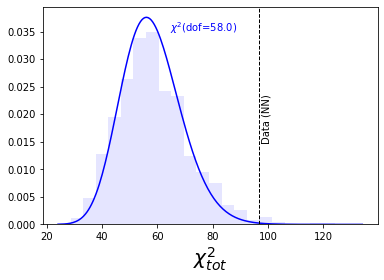

In [11]:
mu = np.mean(chi2s)
std = np.std(chi2s)
print(f'{mu:.1f} +- {std:.1f}')

vmin = 0.9*min(chi2s)
vmax = 1.1*max(chi2s)

bin_width = 3.5*std / np.power(len(chi2s), 1./3.) # Scott 1979
print(bin_width)


bins = np.arange(vmin, vmax, bin_width)
x_ = np.linspace(vmin, vmax, 200)
#pdf = (1./np.sqrt(2*np.pi)/std)*np.exp(-0.5*((x_-mu)/std)**2)
pdf = chi2_pdf(x_, np.floor(mu))

plt.plot(x_, pdf, color='b')
plt.hist(chi2s, bins=bins, alpha=0.1, density=True, color='blue', )
plt.text(1.1*mu, 0.035, rf'$\chi^{2}$(dof={np.floor(mu)})',
         color='b')

plt.axvline(chi2_d, ls='--', lw=1, color='k')
plt.text(1.01*chi2_d, 0.015, 'Data (NN)', rotation=90)

plt.xlabel(r'$\chi^{2}_{tot}$', fontsize=20)
# plt.savefig('chi2_wh.png', dpi=300, bbox_inches='tight')

In [12]:
print(np.mean(np.array(chi2s) > chi2_d))

0.01


In [2]:


class NbarCov:
    
    def __init__(self, c, n, m):
        """ read covariance matrix """
        from glob import glob
        
        path = '/home/mehdi/data/eboss/mocks/1.0/measurements/nnbar/'
        self.mocks = glob(f'{path}nnbar_{c}_knownsystot_mainhighz_512_v7_0_*_main_{n}.npy')
        self.nmocks = m # len(self.mocks)
        self.m = m
        print(f'nmocks: {self.nmocks}, m: {self.m}')

        err_tot = []
        for j, fn in enumerate(self.mocks[:self.m]):
            d = np.load(fn, allow_pickle=True)

            err_j = []
            for i, di in enumerate(d):
                err_j.append(di['nnbar'] - 1.0)
            err_tot.append(err_j)            
        self.err_tot = np.cov(np.array(err_tot).reshape(self.nmocks, -1), 
                              rowvar=False)
        
    def get_chi2mocks(self, start, end):
        invcov = self.get_invcov(0, 136)
        
        chi2_mocks = []
        for nbar_i in self.mocks[start:end]:        
            chi2_t = get_chi2t(nbar_i, invcov)        
            chi2_mocks.append(chi2_t)
            #print('.', end='')

        return np.array(chi2_mocks)        

    def get_invcov(self, start, end, return_covmax=False):
        # https://arxiv.org/pdf/astro-ph/0608064.pdf
        err_tot_ = self.err_tot[start:end, start:end]
        
        nbins = err_tot_.shape[0]        
        print(f'nbins: {nbins}')

        hartlop_factor = (self.nmocks - 1.) / (self.nmocks - nbins - 2.)
        covmax = hartlop_factor * err_tot_
        if return_covmax:
            return np.linalg.inv(covmax), covmax
        else:
            return np.linalg.inv(covmax)

In [3]:
cov = NbarCov('NGC', '512', 1000)
chi2m = cov.get_chi2mocks(0, 1000)
cov = NbarCov('NGC', '512', 900)
chi2n = cov.get_chi2mocks(900, 1000)
cov = NbarCov('NGC', '512', 500)
chi2o = cov.get_chi2mocks(500, 1000)
cov = NbarCov('NGC', '512', 900)
chi2p = cov.get_chi2mocks(0, 900)

nmocks: 1000, m: 1000
nbins: 136
nmocks: 900, m: 900
nbins: 136
nmocks: 500, m: 500
nbins: 136
nmocks: 900, m: 900
nbins: 136


1-1k/1-1k           : 122.7 +- 15.6
1-900/901-1k        : 135.0 +- 18.8
1-500/501-1k        : 141.3 +- 22.7
1-900/1-900         : 120.8 +- 15.2


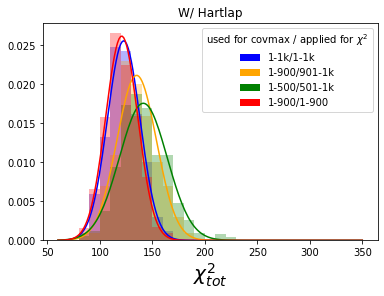

In [6]:
x_ = np.linspace(60, 350, num=200)

c = ['b', 'orange', 'green', 'red']
i = 0

for chi2_, n_ in zip([chi2m, chi2n, chi2o, chi2p],
                     ['1-1k/1-1k', '1-900/901-1k', '1-500/501-1k', '1-900/1-900']):
    
    mu = np.mean(chi2_)
    std = np.std(chi2_)
    
    print(f'{n_:20s}: {mu:.1f} +- {std:.1f}')
    
    pdf = (1./np.sqrt(2*np.pi)/std)*np.exp(-0.5*((x_-mu)/std)**2)
    
    plt.plot(x_, pdf, color=c[i])
    _ = plt.hist(chi2_, alpha=0.3, density=True, 
                 bins=np.arange(60, 360, 10), color=c[i], label=n_)
    i += 1
    
leg = plt.legend(title=r'used for covmax / applied for $\chi^{2}$')    
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r'$\chi^{2}_{tot}$', fontsize=20)
plt.title('W/ Hartlap')
plt.savefig('chi2_wh.png', dpi=300, bbox_inches='tight')

In [3]:
cov = NbarCov('NGC', '512', 1000)
chi2m = cov.get_chi2mocks(900, 1000)
cov = NbarCov('NGC', '512', 900)
chi2n = cov.get_chi2mocks(900, 1000)
cov = NbarCov('NGC', '512', 500)
chi2o = cov.get_chi2mocks(900, 1000)

nmocks: 1000, m: 1000
nbins: 136
nmocks: 900, m: 900
nbins: 136
nmocks: 500, m: 500
nbins: 136


1-1k/901-1k         : 118.3 +- 14.3
1-900/901-1k        : 135.0 +- 18.8
1-500/901-1k        : 137.5 +- 20.0


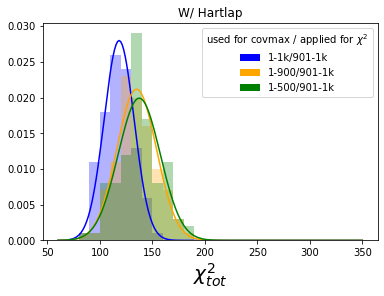

In [4]:
x_ = np.linspace(60, 350, num=200)

c = ['b', 'orange', 'green', 'red']
i = 0

for chi2_, n_ in zip([chi2m, chi2n, chi2o],
                     ['1-1k/901-1k', '1-900/901-1k', '1-500/901-1k']):
    
    mu = np.mean(chi2_)
    std = np.std(chi2_)
    
    print(f'{n_:20s}: {mu:.1f} +- {std:.1f}')
    
    pdf = (1./np.sqrt(2*np.pi)/std)*np.exp(-0.5*((x_-mu)/std)**2)
    
    plt.plot(x_, pdf, color=c[i])
    _ = plt.hist(chi2_, alpha=0.3, density=True, 
                 bins=np.arange(60, 360, 10), color=c[i], label=n_)
    i += 1
    
leg = plt.legend(title=r'used for covmax / applied for $\chi^{2}$')    
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r'$\chi^{2}_{tot}$', fontsize=20)
plt.title('W/ Hartlap')
plt.savefig('chi2_same.png', dpi=300, bbox_inches='tight')

In [10]:
nbar = {}
for c in ['NGC', 'SGC']:
    
    nbar[f'{c}-noweight'] = read_nnbar(c, 'noweight', 'mainhighz', '512', '512')
    nbar[f'{c}-standard'] = read_nnbar(c, 'knownsystot', 'mainhighz', '512', '512')
    nbar[f'{c}-nn'] = read_nnbar(c, 'known', 'mainhighz', '512', '512')

In [14]:
for c in ['NGC', 'SGC']:
    
    for m in ['noweight', 'standard', 'nn']:
        ni = f'{c}-{m}'
        nbari = nbar[ni]
        
        print('%.1f'%chi2(nbari, inv_cov[c]), end=' & ')
    print('')

1369.2 & 240.5 & 186.3 & 
1937.7 & 146.4 & 132.2 & 


In [14]:
print(20*'-', '512 / 512', 20*'-')
read_nnbar('noweight', 'mainhighz', '512', '512', inv_cov=inv_cov_512, select='all')
read_nnbar('knownsystot', 'mainhighz', '512', '512', inv_cov=inv_cov_512, select='all')
read_nnbar('known', 'mainhighz', '512', '512', inv_cov=inv_cov_512, select='all')
read_nnbar('all', 'mainhighz', '512', '512', inv_cov=inv_cov_512, select='all')
read_nnbar('known', 'lowmidhighz', '512', '512', inv_cov=inv_cov_512, select='all')
read_nnbar('all', 'lowmidhighz', '512', '512', inv_cov=inv_cov_512, select='all')
print(20*'-', '256 / 512', 20*'-')
read_nnbar('known', 'mainhighz', '256', '512', inv_cov=inv_cov_512, select='all')
read_nnbar('all', 'mainhighz', '256', '512', inv_cov=inv_cov_512, select='all')
read_nnbar('known', 'lowmidhighz', '256', '512', inv_cov=inv_cov_512, select='all')
read_nnbar('all', 'lowmidhighz', '256', '512', inv_cov=inv_cov_512, select='all')
print(40*'=')
print(20*'-', '512 / 256', 20*'-')
read_nnbar('noweight', 'mainhighz', '512', '256', inv_cov=inv_cov_256, select='all')
read_nnbar('knownsystot', 'mainhighz', '512', '256', inv_cov=inv_cov_256, select='all')
read_nnbar('known', 'mainhighz', '512', '256', inv_cov=inv_cov_256, select='all')
read_nnbar('all', 'mainhighz', '512', '256', inv_cov=inv_cov_256, select='all')
read_nnbar('known', 'lowmidhighz', '512', '256', inv_cov=inv_cov_256, select='all')
read_nnbar('all', 'lowmidhighz', '512', '256', inv_cov=inv_cov_256, select='all')
print(20*'-', '256 / 256', 20*'-')
read_nnbar('known', 'mainhighz', '256', '256', inv_cov=inv_cov_256, select='all')
read_nnbar('all', 'mainhighz', '256', '256', inv_cov=inv_cov_256, select='all')
read_nnbar('known', 'lowmidhighz', '256', '256', inv_cov=inv_cov_256, select='all')
read_nnbar('all', 'lowmidhighz', '256', '256', inv_cov=inv_cov_256, select='all')

-------------------- 512 / 512 --------------------
noweight    , mainhighz   , 1369.2, 10.067
knownsystot , mainhighz   , 240.5, 1.768
known       , mainhighz   , 186.3, 1.370
all         , mainhighz   , 177.2, 1.303
known       , lowmidhighz , 193.2, 1.420
all         , lowmidhighz , 180.4, 1.326
-------------------- 256 / 512 --------------------
known       , mainhighz   , 202.0, 1.485
all         , mainhighz   , 229.5, 1.688
known       , lowmidhighz , 233.1, 1.714
all         , lowmidhighz , 242.6, 1.784
-------------------- 512 / 256 --------------------
noweight    , mainhighz   , 927.7, 6.821
knownsystot , mainhighz   , 227.4, 1.672
known       , mainhighz   , 210.3, 1.546
all         , mainhighz   , 199.1, 1.464
known       , lowmidhighz , 272.4, 2.003
all         , lowmidhighz , 251.3, 1.848
-------------------- 256 / 256 --------------------
known       , mainhighz   , 222.4, 1.635
all         , mainhighz   , 160.7, 1.182
known       , lowmidhighz , 225.8, 1.660
all        

In [8]:
path = '/home/mehdi/data/eboss/data/v7_2/1.0/measurements/nnbar/'
nnbar = lambda m, s, n1, n2:np.load(f'{path}nnbar_NGC_{m}_{s}_{n1}_v7_2_main_{n2}.npy', allow_pickle=True)

In [9]:
nnbars = {}
nnbars['512in512'] = nnbar('known', 'mainhighz', '512', '512')
nnbars['512in256'] = nnbar('known', 'mainhighz', '512', '256')

36.51456044371006 star_density
42.77367871726689 star_density
3.391889725434309 ebv
6.106662128597638 ebv
11.697395458585813 sky_i
5.274915677268986 sky_i
3.6581367033110954 depth_g_minus_ebv
7.022536969225374 depth_g_minus_ebv
3.200372777325092 psf_i
4.439867272550025 psf_i


Text(0, 0.5, '1 + $\\delta$')

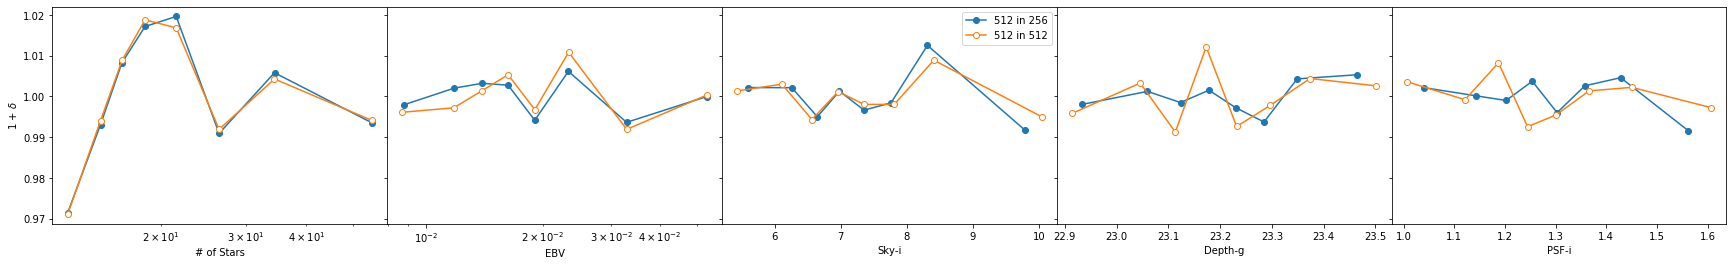

In [10]:
def add_plot(ax, nbar, divide_by_4, **kw):
    bavg = nbar['bin_avg'] * 1.0
    
    if divide_by_4:
        bavg /= 4.
        
    ax.plot(bavg, nbar['nnbar'], **kw)
    #ax.plot(0.5*(nbar['bin_edges'][1:]+nbar['bin_edges'][:-1]), nbar['nnbar'], **kw)
    chi2v  = (((nbar['nnbar']-1)/nbar['nnbar_err'])**2).sum()
    print(chi2v, nbar['sys'])
    
fig, ax = plt.subplots(ncols=5, figsize=(30, 4), sharey=True)
fig.subplots_adjust(wspace=0)

lb = ['# of Stars', 'EBV', 'Sky-i', 'Depth-g', 'PSF-i']

for i, ix in enumerate([0, 1, 5, 7, 13]):
    divide = True if ix==0 else False
    add_plot(ax[i], nnbars['512in256'][ix], divide, marker='o', label='512 in 256')
    add_plot(ax[i], nnbars['512in512'][ix], False, marker='o', mfc='w', label='512 in 512')
    
    ax[i].set(xlabel=lb[i])
    if i < 2:
        ax[i].set_xscale('log')
ax[2].legend()
ax[0].set_ylabel(r'1 + $\delta$')

## Test nbar

In [1]:
import sys
sys.path.append('/home/mehdi/github/LSSutils')
from lssutils.utils import EbossCat
from lssutils.stats.nnbar import MeanDensity

In [2]:
import pandas as pd
import numpy as np

In [3]:
dat_fn = '/home/mehdi/data/eboss/data/v7_2/1.0/catalogs/eBOSS_QSO_full_NGC_all_mainhighz_256_v7_2.ran.fits'
dat256 = EbossCat(dat_fn, kind='randoms', zmin=0.8, zmax=2.2)
dat512 = EbossCat(dat_fn.replace('256', '512'), kind='randoms', zmin=0.8, zmax=2.2)

column QSO_ID not in the randoms file
column IMATCH not in the randoms file
column QSO_ID not in the randoms file
column IMATCH not in the randoms file


In [5]:
dat_fn = '/home/mehdi/data/eboss/data/v7_2/eBOSS_QSO_full_NGC_v7_2.ran.fits'
dat512_ = EbossCat(dat_fn, kind='randoms', zmin=0.8, zmax=2.2)

column QSO_ID not in the randoms file
column IMATCH not in the randoms file


In [6]:
np.var(dat256['WEIGHT_SYSTOT']), np.var(dat512['WEIGHT_SYSTOT']), np.var(dat512_['WEIGHT_SYSTOT'])

(0.005817713228741466, 0.005459346811390732, 0.00313043323865972)

In [4]:
df = pd.read_hdf('/home/mehdi/data/templates/SDSS_WISE_HI_imageprop_nside512.h5', 'templates')

In [5]:
depth_g = df['depth_g_minus_ebv'].values

In [13]:
# case 1
hpdat = dat.to_hp(512, 0.8, 2.2, raw=2)
hpran = ran.to_hp(512, 0.8, 2.2, raw=2)

# case 2
hpran_ = ran.to_hp(512, 0.8, 2.2, raw=1)

/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/pixelfunc.py:481: RuntimeWarning: invalid value encountered in _ang2pix_ring
  return pixlib._ang2pix_ring(nside, theta, phi)


In [24]:
mask = (hpran > 0) & (hpran_ > 0) & (np.isfinite(depth_g))

In [58]:
np.percentile(depth_g[mask], [2, 98])

array([22.83525231, 23.56066845])

In [59]:
bins = np.linspace(22.8, 23.4, 11)
nbar_1 = MeanDensity(hpdat, hpran, mask, depth_g, nbins=10, bins=bins, binning='simple')
nbar_2 = MeanDensity(hpdat, hpran_, mask, depth_g, nbins=10, bins=bins, binning='simple')

In [60]:
nbar_1.run()
nbar_2.run()

(0.9, 1.1)

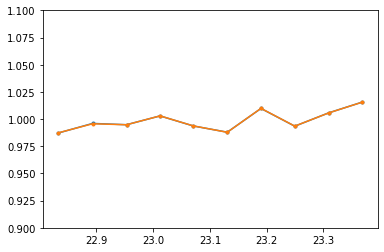

In [62]:
for nbar_i in [nbar_1.output, nbar_2.output]:
    plt.plot(nbar_i['bin_avg'], nbar_i['nnbar'], marker='.')
    
plt.ylim(0.9, 1.1)

In [63]:
dat

catalog : data
# of objects : 218209
z : (0.8000152398143878, 2.199999421096105)
columns : ['RA', 'DEC', 'Z', 'WEIGHT_FKP', 'WEIGHT_SYSTOT', 'WEIGHT_CP', 'WEIGHT_NOZ', 'NZ', 'QSO_ID', 'IMATCH', 'COMP_BOSS', 'sector_SSR']

In [65]:
np.std(dat['WEIGHT_SYSTOT'])

0.052871011877197734